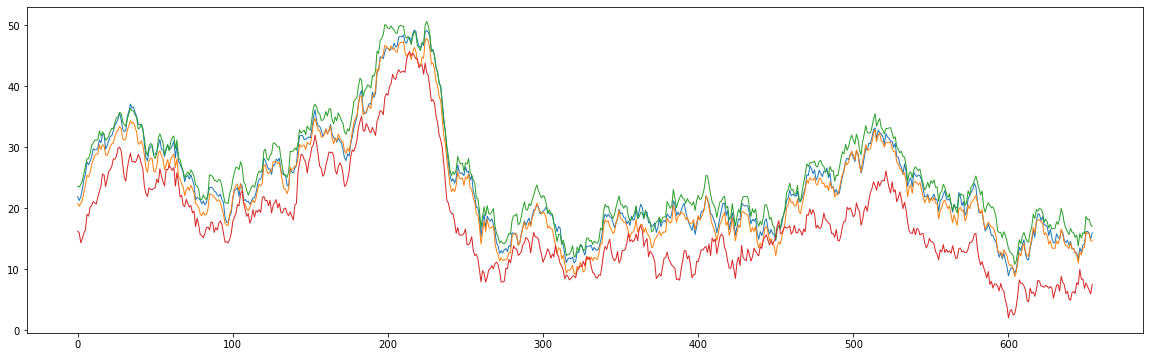

In [2]:
def genOU():
    import numpy as np
    import matplotlib.pyplot as plt
    import sdepy
    import pandas as pd
    
    #######################################################
    # Modify existing code to include real means
    #######################################################
    
    url = 'https://raw.githubusercontent.com/Erik-Chan/Crude-Oil-Data/master/Data/Cleaned_WTI_WSC.csv'
    
    df = pd.read_csv(url)

    df['DateTime'] = pd.to_datetime(df['DateTime'])

    df = df.sort_values(by=['DateTime'])

    df = df.reset_index(drop=True)
    
    # Plot Parameters
    ###########################################
    plt.rcParams['figure.figsize'] = (20, 6)
    plt.rcParams['lines.linewidth'] = 1.
    ###########################################
    np.random.seed(1)

    T = range(0,654)

    #Mean and covariance matrix of the multivariate normal
    mean = (0, 0, 0, 0)
    cov = [[1.0000, 0.8819, 0.8118, 0.5096],
           [0.8819, 1.0000, 0.9744, 0.3065],
           [0.8118, 0.9744, 1.0000, 0.2832],
           [0.5096, 0.3065, 0.2832, 1.0000]]

    #cov = [[4.0000, 2.8819, 2.8118, 2.5096],
    #       [2.8819, 4.0000, 2.9744, 2.3065],
    #       [2.8118, 2.9744, 4.0000, 2.2832],
    #       [2.5096, 2.3065, 2.2832, 4.0000]]

    # Note that if we want to code this ourselves using the Kaiser-Dickman algorithm,
    # we should use the Cholesky decomposition on the covariance matrix. But here
    # we simply let numpy do the work.
    dW = np.random.multivariate_normal(mean, cov, (655))

    # Vector of initial values

    #X_0 = [5, 4.5, 5.25, 0]

    X_0 = [16.27+ 5 + 0.67, 16.27+ 4.5, 16.27 +5.25+ 2.1, 16.27+0]

    #Mean reversion rate
    k = [0.119, 0.119, 0.119, 0.119]
    #k = [2,2,2,2]
    #Mean reversion level
    mu = [16.27+ 5 + 0.67, 16.27+ 4.5, 16.27 +5.25+ 2.1, 16.27+0]
    
    tcost = [5+0.67, 4.5, 5.25+2.1, 0]
    mu = []
    
    for t in T:
        mu.append([df['WTI_WCS_diff'][t] + tcost[i] for i in range(len(X_0))])
    
    #Setting X_0 = X_0
    X_t = [X_0]

    for t in T:
        delXt = []
        for i in range(len(X_0)):
            delXt.append(X_t[t][i] + k[i]*(mu[t][i]-X_t[t][i])+dW[t][i])
        X_t.append(delXt)

    X_t = np.array(X_t)
    return X_t
X_t = genOU()

for i in range(4):
    plt.plot(X_t[:,i])
plt.show()

     WTI   DateTime        WCS  WCS_Interpolated  WTI_Interpolated  \
0  60.37 2018-01-02  35.309689         35.309689             60.37   
1  61.61 2018-01-03  37.674783         37.674783             61.61   
2  61.98 2018-01-04  37.093802         37.093802             61.98   
3  61.49 2018-01-05  36.403316         36.403316             61.49   
4  61.73 2018-01-08  36.347636         36.347636             61.73   

   WTI_WCS_diff  
0     25.060311  
1     23.935217  
2     24.886198  
3     25.086684  
4     25.382364  
[[ 4.2442111   3.61010047  3.92865133 -0.42652609]
 [ 4.91893174  4.92090506  6.02134104  0.51528368]
 [ 3.67509806  2.48538646  3.20285123  0.86971212]
 ...
 [ 3.90576764  3.26736966  4.00469523  0.25488003]
 [ 3.73549132  3.20259156  4.26362001 -1.08632275]
 [ 4.62285962  3.5610366   4.52281068  0.86374023]]
The solution for alpha_s at the minimum is : [3.530000000000001, 3.1799999999999997, 3.289999999999999, 11.910000000000002]
The solution for rho_s at the minim

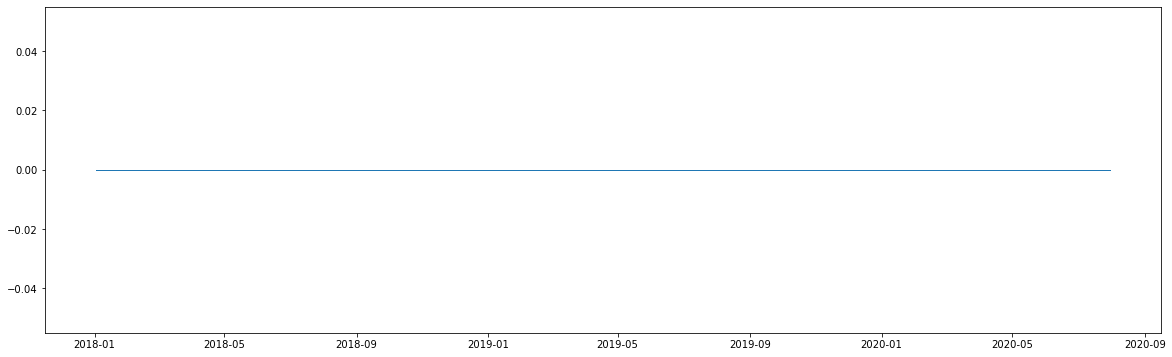

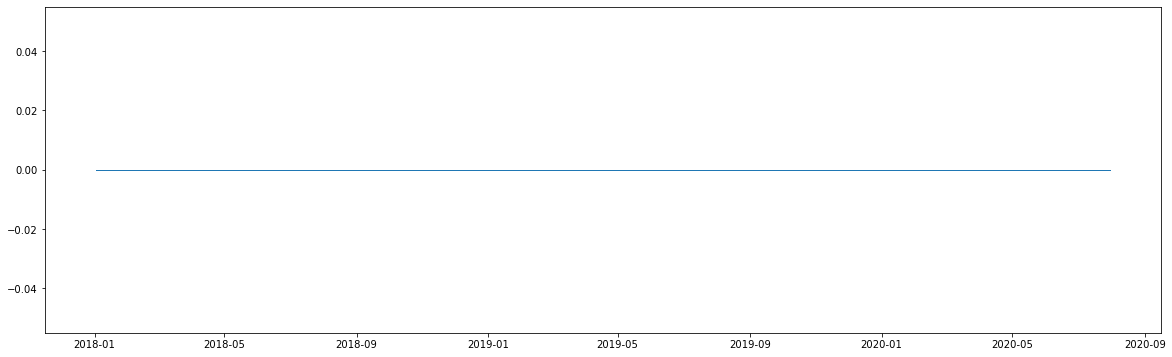

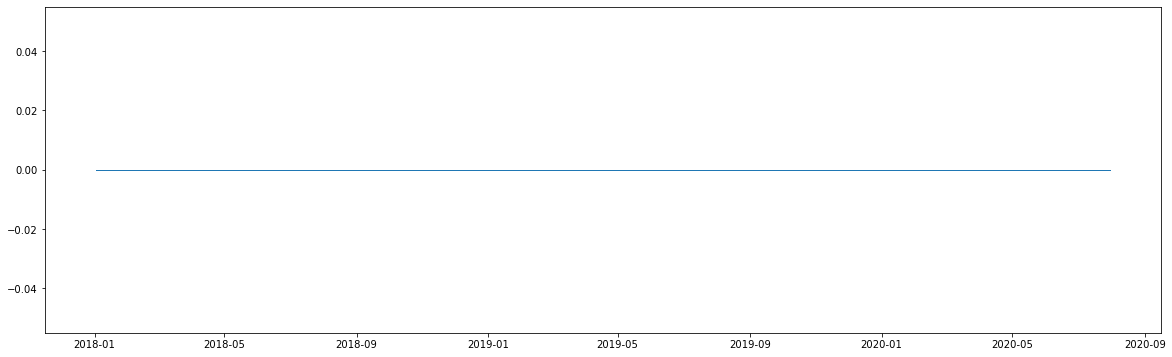

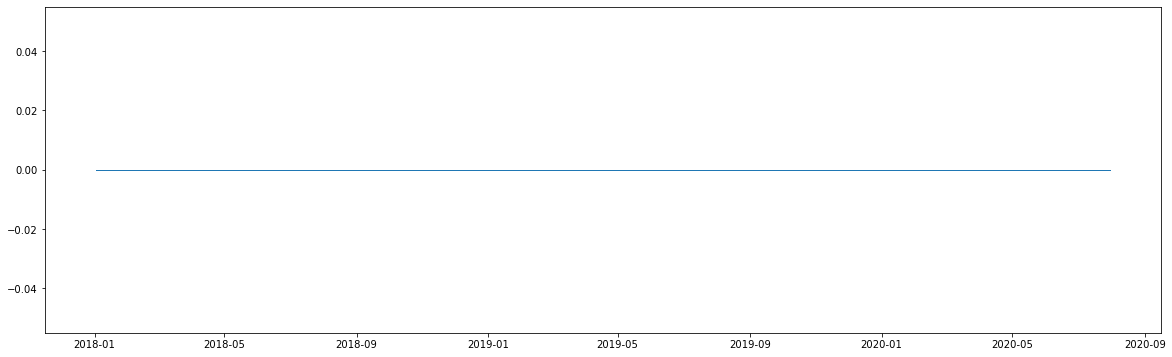

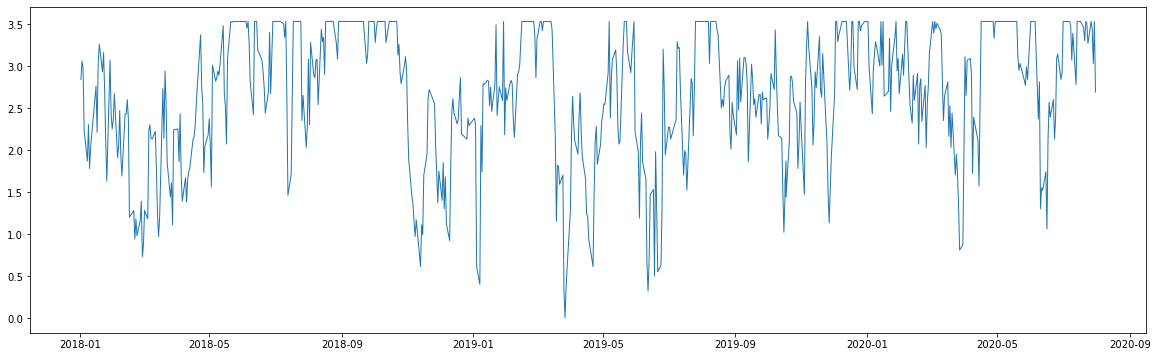

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdepy
from mip import Model, xsum, minimize, BINARY, Var

# Plot Parameters
###########################################
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['lines.linewidth'] = 1.
###########################################
np.random.seed(1)

###################################################################################################################
# Preliminary Data Cleaning
###################################################################################################################

url = 'https://raw.githubusercontent.com/Erik-Chan/Crude-Oil-Data/master/Data/Cleaned_WTI_WSC.csv'

X_t = genOU()

df = pd.read_csv(url)

df['DateTime'] = pd.to_datetime(df['DateTime'])

df = df.sort_values(by=['DateTime'])

#column_names = ['DateTime', 'WTI', 'WCS', 'WCS_Interpolated', 'WTI_Interpolated', 'WTI_WCS_diff']

#df = df.reindex(columns=column_names)
df = df.reset_index(drop=True)
print(df.head())

priceData = df[['DateTime', 'WCS_Interpolated', 'WTI_Interpolated', 'WTI_WCS_diff']]

priceData = df.assign(Edmonton=lambda x: x['WTI_WCS_diff'])

priceData = priceData.assign(Chicago=lambda x: x['WTI_WCS_diff'])

priceData = priceData.assign(Wood_River=lambda x: x['WTI_WCS_diff'])

priceData = priceData.assign(Cushing=lambda x: x['WTI_WCS_diff'])

priceData['Edmonton'] = X_t[:,0]
priceData['Chicago'] = X_t[:,1]
priceData['Wood_River'] = X_t[:,2]
priceData['Cushing'] = X_t[:,3]

###################################################################################################################
# Setting up OU simulations
###################################################################################################################

@sdepy.integrate
def my_ou(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k * (x-theta), 'dw': sigma}
T = 1
t = np.linspace(0, T, 655)

x = my_ou(x0= 16.31, k = 0.011928352054776574, theta = 16.31,
          sigma = 1.00597006920309, paths = 1, steps = len(t))(t)
#x = [item for sublist in x for item in sublist]

mean = (5, 4.5, 5.25, 0)
cov = [[1.0000, 0.8819, 0.8118, 0.5096], 
       [0.8819, 1.0000, 0.9744, 0.3065], 
       [0.8118, 0.9744, 1.0000, 0.2832],
       [0.5096, 0.3065, 0.2832, 1.0000]]
x = np.random.multivariate_normal(mean, cov, (655))

print(x)

###################################################################################################################
# This follows the model on page 21 here:
# http://individual.utoronto.ca/izhu/files/Zhu_FinalPaper2020.pdf
###################################################################################################################

def calc_congestion(beta):
    # time in days
    T = range(len(priceData))

    # The set \mathcal{S} as in the paper
    verts = ['Edmonton', 'Chicago', 'Wood_River', 'Cushing']
    #verts = ['Edmonton', 'Chicago', 'Wood_River', 'Cushing', 'Phantom']
    S = range(len(verts))
    localPrices = priceData[verts].to_numpy()
    localPrices[:,:] = np.round(localPrices[:,:],2)

    # Initialize optimization model object
    model = Model()
    # plt.scatter(sorted(localPrices[:,0]), sorted(localPrices[:,1]))
    # plt.show()
    ###################################################################################################################
    # Constants
    ###################################################################################################################

    # This parameter may need to be relooked at if we investigate spreads
    M = np.max(localPrices[:, :]) - np.min(localPrices[:, :])

    # We set eta_t to be identically equal to 0 because it is causing overfitting problems.
    # eta_t = [0 for t in T]
    # eta_t = [localPrices[:, 0]]
    # print('My eta_t are:', eta_t)
    # plt.plot(eta_t)

    # plt.show()

    lambda_ts = localPrices

    # print('My lambda_t are:', lambda_t)
    # plt.plot(lambda_t)
    # plt.show()
    ###################################################################################################################
    # Variables
    ###################################################################################################################
    # These are the eta_t
    eta_t = np.array([model.add_var() for t in T])

    # These are the alpha_s
    alpha_s = np.array([model.add_var() for s in S])

    # These are the rho_s
    rho_s = np.array([model.add_var() for s in S])

    # These are the eps_st
    eps_st = np.array([[model.add_var() for t in T] for s in S])

    # These are the w_st
    w_st = np.array([[model.add_var() for t in T] for s in S])

    # These are the psi^t
    psi_t = np.array([model.add_var(var_type=BINARY) for t in T])

    # These are the gamma_s^t
    gamma_st = np.array([[model.add_var(var_type=BINARY) for t in T] for s in S])

    # These are the pi_st
    pi_st = np.array([[model.add_var(var_type=BINARY) for t in T] for s in S])
    ###################################################################################################################
    # Constraints
    ###################################################################################################################

    for s in S:
        for t in T:
            # These are constraints (18b)
            model += eta_t[t] + rho_s[s] + eps_st[s][t] + w_st[s][t] == lambda_ts[t][s]
            #model += rho_s[s] + eps_st[s][t] + w_st[s][t] == lambda_ts[t][s]
            # Constraint (18c)
            model += eps_st[s][t] >= -alpha_s[s]

            # Constraint (18d)
            model += eps_st[s][t] <= alpha_s[s]

            # Constraint (18e)
            model += w_st[s][t] <= psi_t[t] * M

    # Constraint (18f)
    model += xsum(psi_t) <= np.floor(beta * len(T))

    for s in S:
        for t in T:
            # Constraint (18g)
            model += w_st[s][t] <= pi_st[s][t] * M

            # Constraint (18h)
            model += eps_st[s][t] + (1 - pi_st[s][t]) * M >= alpha_s[s]

    # Constraint (18i)
    for t in T:
        model += xsum(gamma_st[:, t]) >= psi_t[t]

    # Constraint (18j)
    model += eps_st[s][t] <= -alpha_s[s] + (1 - gamma_st[s][t]) * M

    # Constraint (18k)
    # These are binary constraints see below.

    # Constraint (17l)
    for s in S:
        for t in T:
            model += w_st[s][t] >= 0

    # Set Non-negativity for alpha and rho
    # for s in range(len(verts)):
    # model += alpha_s[s] >= 0
    # model += rho_s[s] >= 2.35
    #for s in S:
        #for t in T:
            #model += eps_st[s][t] >= 0
    ###################################################################################################################
    # Optional Constraints and Variables 21a, 21b, 21c
    ###################################################################################################################
    toggle = 1
    if toggle:
        m = 9

        def T_ub(t, m, T):
            return min(len(T), t + m)

        def T_lb(t, m):
            return max(0, t - m)

        # Variable 21c
        nu_t = np.array([model.add_var(var_type=BINARY) for t in T])
        # These end points may need to be say, t_end+1 etc but we get an index out or range
        # if we do that. I think this should be fine.

        # Constraint 21a
        for t in T:
            t_star = t
            t_end = T_ub(t, m, T)
            psi_t_star = [psi_t[_t] for _t in range(t, t_end)]
            model += xsum(psi_t_star) >= nu_t[t] * (len(T) - t_end)

        # Constraint 21b
        for t in T:
            t_star = T_lb(t, m)
            nu_t_star = [nu_t[_t] for _t in range(t_star, t)]
            model += psi_t[t] <= xsum(nu_t_star)

    ###################################################################################################################
    # Objective Function
    ###################################################################################################################

    # Objective function (20a)
    model.objective = minimize(xsum(alpha_s))

    ###################################################################################################################
    # Optimization
    ###################################################################################################################

    # If toggle_optimize != 0, we proceed with the optimization.
    toggle_optimize = 1
    display_parameters = 1
    if toggle_optimize:
        model.optimize()
        # if model.num_solutions:
        if display_parameters:
            print('The solution for alpha_s at the minimum is :', [opt.x for opt in alpha_s])
            print('The solution for rho_s at the minimum is :', [opt.x for opt in rho_s])
            Plot_W_List = []
            for s in S:
                W_list = []
                eps_list = []
                for t in T:
                    W_list.append(w_st[s][t].x)
                    W_list = [round(w, 2) for w in W_list]
                    eps_list.append(eps_st[s][t].x)
                print('The solution for til_W at city {} is:'.format(verts[s]), W_list)
                Plot_W_List.append(W_list)
                print('The solution for eps_st at city {} is:'.format(verts[s]), eps_list)
                print('The sum of eps at city {} is:'.format(verts[s]), sum(eps_list))

            psi_list = []
            eta_list = []
            for t in T:
                psi_list.append(psi_t[t].x)
                eta_list.append(eta_t[t].x)
            print('The solution for eta^t is:', eta_list)
            print('The solution for psi^{t} is:', psi_list)
            print('The sum of psi is:', np.sum(psi_list))

            flat_gamma = [item for sublist in gamma_st for item in sublist]
            flat_gamma = [gam.x for gam in flat_gamma]
            print('The sum of the gamma are:', sum(flat_gamma))
            # print('My eta_t are:', [sol.x for sol in eta_t])
        surchargeW = []
        for t in T:
            surchargeW.append([eta_t[t].x+rho_s[0].x+alpha_s[0].x-lambda_ts[t][0]])
    return Plot_W_List, [opt.x for opt in alpha_s], surchargeW


# beta = np.array([0. , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.44, 0.49,
# 0.55, 0.6 , 0.65, 0.7 , 0.74, 0.8 , 0.85, 0.9 , 0.95])
beta = np.arange(0.05, 1, 0.05)
omegaList = []
W_list = []
beta = [0.1]
for b in beta:
    W, obj_val, sW = calc_congestion(b)
    omegaList.append([sum(s) for s in W])
    W_list.append(W)

    for s in W_list:
        for ss in s:
            plt.plot(df['DateTime'], ss)
            plt.show()
    plt.plot(df['DateTime'], sW)
    plt.show()
#outputDataW = pd.DataFrame({'beta': np.round(beta, 2), 'W': W_list, 'Objective Value': obj_val, 'Sum w': np.round(omegaList, 2)})
# outputData = pd.DataFrame({'beta': np.round(beta,2), 'Sum w': np.round(omegaList,2)})
# outputData.to_csv('zbeta_data.csv')

#outputDataW.to_csv('Total data.csv')

Define the node from Edmonton

Spread Price + 5.45 + unif(0, 1.35) + 5

Define the node from Chicago

Spread Price + 4.4

Define the node from Wood River (Keystone)

Spread Price + 5.25 + unif (0, 4.2)

Define the node from Cushing (Keystone only)

Spread Price + 6.30 + unif(0, 4.15)

Define the node from Cushing 

Spread Price

The solution for rho_s at the minimum is : [7.9, 6.74, 10.610000000000003, 2.34]